In [2]:
#%pip install langchain
#%pip install langchain-community
#%pip install sentence-transformers
#%pip install tensorflow
#%pip install tf-keras
#%pip install tensorflow-cpu==2.16.1
#%pip install tf-keras==2.16.0
#%pip install faiss-cpu

In [3]:
class Docs:
    def __init__(self, passagedocid2passage, did2pid2id):
       self.passagedocid2passage = passagedocid2passage
       self.did2pid2id = did2pid2id

    def passage_by_id(self, id):
        return self.passagedocid2passage[id]
    
    def docid_passage_id_to_id(self, docid, passage_id):
        return self.did2pid2id[docid][passage_id]

    def number_of_passages(self):
        return len(self.passagedocid2passage)   

    def get_positional_passage(self, position):
        return list(self.passagedocid2passage.keys())[position]

In [4]:
import os
import json
from typing import Dict

class DocsLoader:
    def __init__(self, docs_dir):
        self.docs_dir = docs_dir
        self.dos = []
        
        self.passagedocid2passage = {}
        self.did2pid2id: Dict[str, Dict[str, str]] = {}

        self.load_docs()
        self.load_dics()

    def load_data(self):
        self.load_docs()
        self.load_dics()

        return Docs(self.passagedocid2passage, self.did2pid2id)

    def load_docs(self):
        ndocs = 40
        docs = []
        for i in range(1, ndocs + 1):
            with open(os.path.join(self.docs_dir, f"{i}.json")) as f:
                doc = json.load(f)
                docs.append(doc)  

        self.docs = docs          


    def load_dics(self):
        for doc in self.docs:
            for psg in doc:
                if psg['Passage'] != "":
                    self.passagedocid2passage[psg['ID']] = psg['Passage']
                    self.did2pid2id.setdefault(psg["DocumentID"], {})
                    self.did2pid2id[psg["DocumentID"]].setdefault(psg["PassageID"], psg["ID"])

In [5]:
class Query:
    def __init__(self, query_question, relevant_passages, label):
        self.query_question = query_question
        self.relevant_passages = relevant_passages
        self.label = label

In [6]:
class QueriesLoader:
    def __init__(self, queries_dir, docs: Docs):
        self.queries_dir = queries_dir
        self.docs = docs

    def load_queries(self):
        queries = {}
        with open(self.queries_dir) as f:
            questions = json.load(f)
            for question in questions:
                passages = question["Passages"]
                ids = []
                for passage in passages:
                    docid = passage["DocumentID"]
                    pid = passage["PassageID"]
                    id = self.docs.docid_passage_id_to_id(docid, pid)
                    ids.append(id)

                query = Query(question["Question"], ids, 1)
                queries[question["QuestionID"]] = query

        return queries

In [7]:
docs_dir = "./ObliQADataset/StructuredRegulatoryDocuments"
docs = DocsLoader(docs_dir).load_data()

In [8]:
queries_pat = "ObliQADataset/ObliQA_train.json"
queries = QueriesLoader(queries_pat, docs).load_queries()

In [9]:
dev_queries_path = "ObliQADataset/ObliQA_dev.json"
dev_queries = QueriesLoader(dev_queries_path, docs).load_queries()

In [10]:
import random

class QueriesGenerator:
    def __init__(self, original_queries, docs:Docs):
        self.original_queries = original_queries
        self.docs = docs


    def generate_queries(self):
        new_queries = {}
        for query_id, query in self.original_queries.items():
            print('Generating false matches queries for query: ', query_id)
            new_passages = self.get_n_passages_different_of(query.relevant_passages, len(query.relevant_passages))
            new_query = Query(query.query_question, new_passages, 0)
            new_queries[query_id] = new_query

        return new_queries    

    def get_n_passages_different_of(self, forbidden_passages, n):
        number_of_passages = self.docs.number_of_passages()
        passages = []

        while len(passages) != n:
            rand_int = random.randint(0, number_of_passages - 1)
            false_passage = self.docs.get_positional_passage(rand_int)
            if false_passage not in forbidden_passages and false_passage not in passages:
                passages.append(false_passage)

        return passages

In [11]:
generated_queries = QueriesGenerator(queries, docs).generate_queries()

Generating false matches queries for query:  a10724b5-ad0e-4b69-8b5e-792aef214f86
Generating false matches queries for query:  3382f629-e1c0-49dd-9bd0-61ed0bdce2e6
Generating false matches queries for query:  7073c16e-1974-4051-9064-9f5706c663c7
Generating false matches queries for query:  402bc55d-3881-4239-a9ee-bee60f4e9d3d
Generating false matches queries for query:  5fc3ea5d-071f-4097-acc2-2c89bdec9257
Generating false matches queries for query:  eff925af-4063-47c0-b5ef-f2b07c80df1d
Generating false matches queries for query:  63a71960-e639-4716-9924-a9d1995eb292
Generating false matches queries for query:  862c119a-bab6-4816-823f-ecd2939bebdc
Generating false matches queries for query:  d491b732-207f-4bb1-abae-d2811df8e2fc
Generating false matches queries for query:  a49e8290-54c0-4e2a-8755-1ac2711e5396
Generating false matches queries for query:  22f44218-0f31-4639-bc60-1197ef108a65
Generating false matches queries for query:  75a9272d-e102-4b1f-936e-fc483c7c1617
Generating false

In [12]:
generated_queries["a10724b5-ad0e-4b69-8b5e-792aef214f86"].relevant_passages

['08c98b1e-b3e6-4845-857a-4ea160002bc0']

In [13]:
class Queries:
    def __init__(self, queries_match, queries_no_match):
        self.queries_match = queries_match
        self.queries_no_match = queries_no_match

In [14]:
all_queries = Queries(queries, generated_queries)
dev_queries = Queries(dev_queries, {})

In [15]:
from langchain.embeddings import HuggingFaceEmbeddings
import pickle

class EmbeddingLibrary():
    def __init__(self, docs: Docs, all_queries: Queries):
        self.docs = docs
        self.all_queries = all_queries
        self.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
        self.docs_embeddings = {}
        self.queries_embeddings = {}

        self.generate_docs_embeddings()
        self.generate_queries_embeddings()

    def generate_docs_embeddings(self):
        docs_embeddings = {}
        for id, passage in self.docs.passagedocid2passage.items():
            print('Generating embedding for passage: ', id)
            docs_embeddings[id] = self.embeddings.embed_query(passage)

        self.docs_embeddings = docs_embeddings

    def generate_queries_embeddings(self):
        queries_embeddings = {}
        for id, query in self.all_queries.queries_match.items():
            print('Generating embedding for query: ', id)
            queries_embeddings[id] = self.embeddings.embed_query(query.query_question)

        self.queries_embeddings = queries_embeddings    

    def get_docs_embedding(self, doc_id):
        return self.docs_embeddings[doc_id]
    
    def get_query_embedding(self, query_id):
        return self.queries_embeddings[query_id]
    
    def save(self, path):
        with open(path, "wb") as file:
            pickle.dump(self, file)

    @staticmethod
    def load_docs_embeddings(path):
        with open(path, "rb") as file:
            return pickle.load(file)

In [ ]:
embedding_model_path = "embedding_library.pkl"
if os.path.isfile(embedding_model_path):
    embedding_library = EmbeddingLibrary.load_docs_embeddings(embedding_model_path) 
else:
    embedding_library = EmbeddingLibrary(docs, all_queries)
    embedding_library.save(embedding_model_path)

/opt/anaconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [16]:
len(embedding_library.get_query_embedding("a1f0ab53-af49-4c54-98f4-0e2694c443a7"))

384

In [17]:
class Data:
    def __init__(self, X, y):
        self.X = X
        self.y = y

In [18]:
class NeuronalDataGenerator():
    def __init__(self, embedding_library: EmbeddingLibrary, queries: Queries, docs: Docs):
        self.embedding_library = embedding_library
        self.queries = queries
        self.docs = docs

    def generate_data(self):
        X = []
        y = []
        
        x_match, y_match = self.generate_X_y_from_query_doc(self.queries.queries_match, 1)
        x_no_match, y_no_match = self.generate_X_y_from_query_doc(self.queries.queries_no_match, 0)

        X.extend(x_match)
        X.extend(x_no_match)

        y.extend(y_match)
        y.extend(y_no_match)

        return Data(X, y)

    def generate_X_y_from_query_doc(self, query_dic, label):
        X = []
        y = []
        for question_id, query in query_dic.items():
            passages_ids = query.relevant_passages
            for passage_id in passages_ids:  
                x = self.generate_embedding(question_id, passage_id)

                assert len(x) == 384 * 2
                X.append(x)
                y.append(label)

        return X, y

    def generate_embedding(self, query, doc):
        embedding = []
        query_embedding = self.embedding_library.get_query_embedding(query)
        doc_embedding = self.embedding_library.get_docs_embedding(doc)

        embedding.extend(query_embedding)
        embedding.extend(doc_embedding)

        return embedding

        

In [19]:
class TestDataGenerator:
    def __init__(self, queries, embedding_library):
        self.queries = queries.queries_match  
        self.embeddings_dict = {}
        self.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
        self.embedding_library = embedding_library

        self.generate_query_embedding()
    
    def generate_query_embedding(self):
        embeddings_dict = {}
        for id, query in self.queries.items():
            question = query.query_question
            query_embedding = self.embeddings.embed_query(question)

            embeddings_dict[id] = query_embedding

        self.embeddings_dict = embeddings_dict

    def generate_X_y(self):
        X = []
        y = []
        for query_id, query in self.queries.items():
            for passage_id in query.relevant_passages:
                doc = self.embedding_library.get_docs_embedding(passage_id)
                query = self.embeddings_dict[query_id]

                x = []
                x.extend(query)
                x.extend(doc)

                X.append(x)
                y.append(1)

        return Data(X, y)            
    
    def save(self, path):
        with open(path, "wb") as file:
            pickle.dump(self, file)

    @staticmethod
    def load_docs_embeddings(path):
        with open(path, "rb") as file:
            return pickle.load(file)

In [20]:
dev_data_path = "dev_data.pkl"

train_data = NeuronalDataGenerator(embedding_library, all_queries, docs).generate_data()

if os.path.isfile(dev_data_path):
    dev_generator = TestDataGenerator.load_docs_embeddings(dev_data_path)
else:
    dev_generator = TestDataGenerator(dev_queries, embedding_library)
    dev_generator.save(dev_data_path)


In [21]:
dev_data = dev_generator.generate_X_y()

In [22]:
len(dev_data.X[0])

768

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Crear el modelo secuencial
model = Sequential()

# Agregar las capas
model.add(Dense(264, input_shape=(768,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 264)            │       203,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,033 (863.41 KB)

 Trainable params: 221,033 (863.41 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import numpy as np
X_train = np.array(train_data.X)
y_train = np.array(train_data.y)

X_val = np.array(dev_data.X)
y_val = np.array(dev_data.y)

In [25]:
history = model.fit(
    X_val, y_val,
    epochs=4,                 # Número de épocas
    batch_size=8,             # Tamaño de lote
)

Epoch 1/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9909 - loss: 0.0378
Epoch 2/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.2551e-06
Epoch 3/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.6045e-07
Epoch 4/4
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 6.1161e-08


In [26]:
test_data_path = "test_data.pkl"
test_queries_path = "ObliQADataset/ObliQA_test.json"
test_queries = QueriesLoader(dev_queries_path, docs).load_queries()

test_queries = Queries(test_queries, {})

if os.path.isfile(test_data_path):
    test_generator = TestDataGenerator.load_docs_embeddings(test_data_path)
else:
    test_generator = TestDataGenerator(test_queries, embedding_library)
    test_generator.save(test_data_path)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


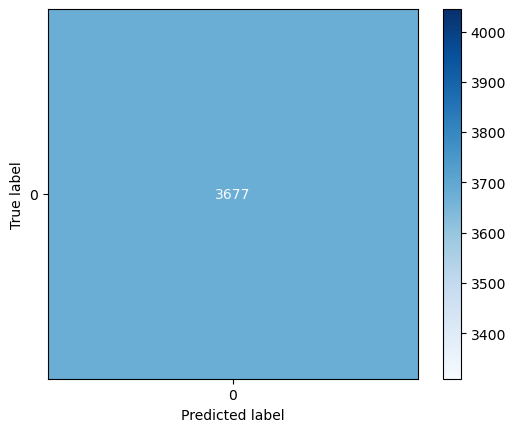

In [27]:
test_data = dev_generator.generate_X_y()
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supongamos que test_data.X y test_data.y son tus datos de prueba
X_test = np.array(test_data.X)
y_test = np.array(test_data.y)

# Realizar predicciones con el modelo
y_pred_prob = model.predict(X_test)

# Convertir probabilidades en etiquetas discretas (umbral 0.5 para clasificación binaria)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [1]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

class DocsRetriever:
    def __init__(self, model, embedding_library: EmbeddingLibrary, docs: Docs):
        self.model = model
        self.embedding_library = embedding_library
        self.docs = docs
        self.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

    def retrieve_k_elements(self, k, query):
        scores = self.scores_of_query(query)
        
        scores_value = scores.values()
        items = scores.items()

        elements = []
        most_similar_indices = np.argsort(scores_value)[-k:][::-1]

        for index in most_similar_indices:
            elements.append(items[index])

        return elements

    def scores_of_query(self, query):
        query_embedding = self.embeddings.embed_query(query)
        docs_embeddings = self.embedding_library.docs_embeddings

        scores = {}
        index = 0
        for doc_id, doc_embedding in docs_embeddings.items():
            x = []
            x.extend(query_embedding)
            x.extend(doc_embedding)
            x = np.array([x])
            score = self.model.predict(x)
            scores[doc_id] = score

            print(index)
            index += 1

        return scores

NameError: name 'EmbeddingLibrary' is not defined

In [ ]:
doc_retriever = DocsRetriever(model, embedding_library, docs)
docs = doc_retriever.retrieve_k_elements(10, "Does ADGM provide any training or resources to assist Relevant Persons in understanding and implementing TFS compliance measures effectively?")

/var/folders/8l/vplxys1s51594wz4l7nk_c780000gn/T/ipykernel_25585/2241693418.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step23368989-55c6-4940-abc6-d7a8d2d1071b
e563ad09-df80-435c-a497-eeec420efbc4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1389d0fa-5346-4953-8d52-45d7fd96c5e8
752659a9-d3f6-416f-ba24-64d290addf6e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step27ce8ea5-92f0-4c42-8d87-15487ff3831

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

bd35fb2d-4de6-48fb-ab3c-baead722854f
e232dec1-7c39-4af1-a9df-7a680ca97af5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
fd448e80-96c3-40a0-a9b9-2b3800848990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
6e789b27-670d-4f36-9f49-d704ae07d9e1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/stepcb391e87-9024-4e63-ac62-95ecf9297697
1/1 ━━━━━━━━━━━━━━━━